## HW3 Starter Code: 524 Spring 2023

## Q1 Car Rental

The minimal total cost is $152.63901632295628. 

With flows between agencies:
* 2-->3: 1.0
* 2-->6: 5.0
* 2-->7: 1.0
* 5-->4: 3.0
* 8-->10: 4.0
* 9-->1: 2.0
* 9-->3: 3.0
* 9-->10: 1.0

In [29]:
using Pkg
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)
agency = [1:10...]
x = [0 20 18 30 35 33 5 5 11 2]
y = [0 20 10 12 0 25 27 10 0 15]
need = [10 6 8 11 9 7 15 7 9 12]
have = [8 13 4 8 12 2 14 11 15 7]
dist = zeros(10, 10)

@variable(m, give[agency, agency] >= 0)
@variable(m, receive[agency, agency] >= 0)

for i in agency
    for j in agency
        dist[i,j] = sqrt((x[i]-x[j])^2+(y[i]-y[j])^2)*1.3
        @constraint(m, give[i,j] == receive[j,i])
        if i==j
            @constraint(m, give[i,j] == 0)
        end
    end
end

@constraint(m, res[i in agency], have[i]+sum(receive[i,j] for j in agency)-sum(give[i,j] for j in agency) == need[i] )

@objective(m, Min, 0.5*0.5*sum((give[i,j]+receive[i,j])*dist[i,j] for i in agency, j in agency))

optimize!(m)
println("Total cost will be \$", objective_value(m))
for i in agency
    for j in agency
        if value.(give)[i,j] > 0
            println(i,"-->",j,": ",value.(give)[i,j])
        end
    end
end

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
10 rows, 90 cols, 180 nonzeros
0; Iter: Time           0; average =           0; Bound =           0
9 rows, 90 cols, 162 nonzeros
Presolve : Reductions: rows 9(-111); columns 90(-110); elements 162(-248)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 9(35) 0s
          9     1.5263901632e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 9
Objective value     :  1.5263901632e+02
HiGHS run time      :          0.00
Total cost will be $152.63901632295628
2-->3: 1.0
2-->6: 5.0
2-->7: 1.0
5-->4: 3.0
8-->10: 4.0
9-->1: 2.0
9-->3: 3.0
9-->10: 1.0


## Q2 Data for Stadium Building Problem

(This is the data needed for part (b). Part (a) of the problem will not need all this data.)

In [30]:
using JuMP

tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

# additional columns of data (maximum reduction possible )
max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]  # max reduction (in weeks)
cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]  # cost of reduction ($1,000/week)
bonus_amount = 30     # bonus for expediting the project ($1,000/week )
;

pred_dict

Dict{Int64, Vector} with 18 entries:
  5  => [3]
  16 => [8, 11, 14]
  7  => [4]
  12 => [9]
  8  => [6]
  17 => [12]
  1  => Any[]
  4  => [2]
  6  => [4, 5]
  13 => [7]
  2  => [1]
  10 => [4]
  11 => [6]
  9  => [4, 6]
  15 => [4, 14]
  18 => [17]
  14 => [2]
  3  => [2]

### a)
The earliest possible week to complete is 64.0.

In [83]:
using JuMP, HiGHS
m1 = Model(HiGHS.Optimizer)
task = [1:18...]
@variable(m1, time[task] >= 0)
@expression(m1, endtime[i in task], time[i]+durations[i])

for i in task
   for pre in pred_dict[i]
        @constraint(m1, time[i] >= time[pre]+durations[pre])
    end
end

@objective(m1, Min, sum(endtime[i] for i in task))
optimize!(m1)

maxtime = 0
endweeki = 0
for i in task
    if value.(endtime)[i] > maxtime
        maxtime = value.(endtime)[i]
        endweeki = i
    end
end
println("Earliest week is ", maxtime)

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
19 rows, 14 cols, 37 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-22); columns 0(-18); elements 0(-44) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.6900000000e+02
HiGHS run time      :          0.00
Earliest week is 64.0


### b)
The week to complete is 57.0. The maximum profit is $87.0k.

In [85]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
task = [1:18...]
@variable(m, time[task] >= 0)
@variable(m, save[task] >= 0)
@expression(m, endtime[i in task], time[i]+durations[i]-save[i])
@expression(m, cost, sum(save[i]*cost_reduction[i] for i in task))
@expression(m, profit, (maxtime-endtime[endweeki])*bonus_amount-cost)

for i in task
    @constraint(m, save[i] <= max_reduction[i])
   for pre in pred_dict[i]
        @constraint(m, time[i] >= endtime[pre])
    end
end

@objective(m, Max, profit)
optimize!(m)

endweek = 0
for i in task
    if value.(endtime)[i] > endweek
        endweek = value.(endtime)[i]
    end
end
println("Complete week is ", endweek)  
println("Max profit will be \$", bonus_amount*(maxtime-endweek)-value.(cost), "k")

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
14 rows, 18 cols, 39 nonzeros
3 rows, 6 cols, 11 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-40); columns 0(-36); elements 0(-84) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  8.7000000000e+01
HiGHS run time      :          0.00
Complete week is 57.0
Max profit will be $87.0k


## Q3 Starter Code for Battery Charge Problem

In [87]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)

capacity = 30
demand = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]



# Insert here your code to build the model and solve the problem

1×24 Matrix{Int64}:
 43  40  36  36  35  38  41  46  49  …  47  50  63  75  75  72  66  57  50

### a)
Minimum cost is $143400.0.

In [96]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
hours = [1:24...]
@variable(m, purchasel[hours] >= 0)
@variable(m, purchaseh[hours] >= 0)
@variable(m, battery[1:25] >= 0)
@expression(m, cost, 100*sum(purchasel[i] for i in hours) + 400*sum(purchaseh[i] for i in hours))
@expression(m, purchased[i in hours], purchaseh[i]+purchasel[i])

@constraint(m, battery[1] == 0)
for i in hours
    @constraint(m, purchaseh[i] <= 15)
    @constraint(m, purchasel[i] <= 50)
    @constraint(m, battery[i] <= capacity)
    @constraint(m, purchaseh[i]+purchasel[i]+battery[i] == demand[i]+battery[i+1])
end

@objective(m, Min, cost)
optimize!(m)

println("Minimum cost is \$", value.(cost))


Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
24 rows, 71 cols, 94 nonzeros
20 rows, 60 cols, 79 nonzeros
20 rows, 58 cols, 77 nonzeros
Presolve : Reductions: rows 20(-77); columns 58(-15); elements 77(-92)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     4.3000000000e+04 Pr: 20(905) 0s
         37     1.4340000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 37
Objective value     :  1.4340000000e+05
HiGHS run time      :          0.00
Minimum cost is $143400.0


In [94]:
# add the plotting package Gadfly
using Pkg
Pkg.add("Gadfly")
Pkg.build


   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`


build (generic function with 7 methods)

### b)
During 19 to 21 hours is necessary to purchase electricity at the higher rate. The demand is high, and the battery is drained.

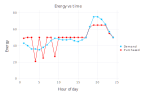

In [97]:
# this code will plot the demand (given in the starter code above) 
# and the value of the variable "purchased".
# Make sure the variable "purchased" is defined correctly by the code you write for part (a)
using Gadfly
plot(layer( x=1:24, y=demand, Geom.point, Geom.line ),
layer( x=1:24, y=value.(purchased), Geom.point, Geom.line, Theme(default_color=colorant"red") ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Demand", "Purchased"],
                            [Gadfly.current_theme().default_color, "red"]))

### c)

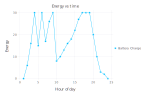

In [102]:
plot(layer( x=1:24, y=value.(battery[1:24]), Geom.point, Geom.line),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Battery Charge"]))

### d)

Minimum cost is $120000.0
Battery’s capacity actually used 108.0 MWh.

In [104]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
hours = [1:24...]
@variable(m, purchasel[hours] >= 0)
@variable(m, purchaseh[hours] >= 0)
@variable(m, battery[1:25] >= 0)
@expression(m, cost, 100*sum(purchasel[i] for i in hours) + 400*sum(purchaseh[i] for i in hours))
@expression(m, purchased[i in hours], purchaseh[i]+purchasel[i])

@constraint(m, battery[1] == 0)
for i in hours
    @constraint(m, purchaseh[i] <= 15)
    @constraint(m, purchasel[i] <= 50)
    @constraint(m, purchaseh[i]+purchasel[i]+battery[i] == demand[i]+battery[i+1])
end

@objective(m, Min, cost)
optimize!(m)

println("Minimum cost is \$", value.(cost))
println("Battery’s capacity actually used ", maximum(value.(battery)))
    

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
24 rows, 72 cols, 95 nonzeros
18 rows, 54 cols, 71 nonzeros
18 rows, 54 cols, 71 nonzeros
Presolve : Reductions: rows 18(-55); columns 54(-19); elements 71(-74)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 18(1200) 0s
         18     1.2000000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 18
Objective value     :  1.2000000000e+05
HiGHS run time      :          0.00
Minimum cost is $120000.0
Battery’s capacity actually used 108.0


### e)

In this case it doesn't need to purchase at higher rate at any time, because the battery capacity is infinity, and it is enough to use the electricity that purchased at lower rate before.

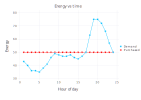

In [105]:
using Gadfly
plot(layer( x=1:24, y=demand, Geom.point, Geom.line ),
layer( x=1:24, y=value.(purchased), Geom.point, Geom.line, Theme(default_color=colorant"red") ),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Demand", "Purchased"],
                            [Gadfly.current_theme().default_color, "red"]))

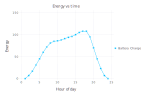

In [106]:
plot(layer( x=1:24, y=value.(battery[1:24]), Geom.point, Geom.line),
Guide.xlabel( "Hour of day"), Guide.ylabel("Energy"), Guide.title("Energy vs time"), Guide.manual_color_key("",["Battery Charge"]))